In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
#import gymnasium as gym
import numpy as np
from envs.two_player_dubins_car import TwoPlayerDubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm


In [103]:
# Define the policy network
def policy_network_nash(observation):
    net = hk.Sequential([
        hk.Linear(64), jax.nn.relu,
        hk.Linear(64), jax.nn.relu,
        hk.Linear(env.num_actions),
        jax.nn.softmax
    ])
    return net(observation)

def policy_network_stackelberg(observation, legal_moves):
    net = hk.Sequential([
        hk.Linear(64), jax.nn.relu,
        hk.Linear(64), jax.nn.relu,
        hk.Linear(env.num_actions),
        jax.nn.softmax

    ])
    logits = net(observation)

    masked_logits = jnp.multiply(logits, legal_moves)
    probabilities = jax.nn.softmax(masked_logits)
    return probabilities



# def policy_network_stackelberg(observation, legal_moves):
#     net = hk.Sequential([
#         hk.Linear(400), jax.nn.relu,
#         hk.Linear(400), jax.nn.relu,
#         hk.Linear(400), jax.nn.relu,
#         hk.Linear(400), jax.nn.relu,
#         hk.Linear(env.num_actions),
#         jax.nn.softmax

#     ])
#     logits = net(observation)

#     masked_logits = jnp.multiply(logits, legal_moves)
#     probabilities = jax.nn.softmax(masked_logits)
#     return probabilities

In [3]:
import pickle
# Load the trained policy
with open('data/stackelberg/2023-05-11 13:09:02.276650_episode_88_params.pickle', 'rb') as handle:
        loaded_params = pickle.load(handle)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [132]:
def test_policy(env, params, policy_net, state=None, game_type='nash', make_gif=True, filename='episode.gif', random_player='g'):
    
    if game_type == 'nash':
        policy_net = hk.without_apply_rng(hk.transform(policy_network_nash))
    elif game_type == 'stackelberg':
        policy_net = hk.without_apply_rng(hk.transform(policy_network_stackelberg))
    
    
    key = jax.random.PRNGKey(1)

    if state is None:
        state = env.reset()
    #state = env.set(-2., 0., 0., 3., 0., 0.)
    #state = env.reset()
    nn_state = env.encode_helper(state)
    frames = []
    done = False
    episode_length = 0
    attacker_rewards = []

    while not done and episode_length < 200:
        for player in env.players:
        
            key, subkey = jax.random.split(key)

            if game_type == 'nash':
                probs = policy_net.apply(params[player], nn_state)
            elif game_type == 'stackelberg':
                
                legal_actions_mask = env.get_legal_actions_mask(state, player)
               # print(legal_actions_mask)
                probs = policy_net.apply(params[player], nn_state, legal_actions_mask)



            if player == random_player:
                bad_probs = np.array([33, .34, .33])

                action = jax.random.categorical(subkey, bad_probs) #jax.random.randint(subkey, shape=(), minval=0, maxval=3)
            else:
                #action = jax.random.categorical(subkey, probs)
                action = jnp.argmax(probs)

            state, rewards, done, info = env.step(state=state, action=action, player=player, update_env=True)
            if player == 'attacker': attacker_rewards.append(rewards)

            nn_state = env.encode_helper(state)
            episode_length += 1
            if make_gif: 
                env.render()
                print(info)

    if make_gif: 
        img = env.make_gif("two_player_animation_test.gif")
        return attacker_rewards, img
    else:
        return attacker_rewards


In [93]:
import glob

files_nash = glob.glob('data/nash/2023-05-12 03:56:25.017833_episode*.pickle')
files_nash.sort(key=lambda x: int(x.split("_episode_")[1].split("_params.pickle")[0]))
files_nash

['data/nash/2023-05-12 03:56:25.017833_episode_0_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_500_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_1000_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_1500_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_2000_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_2500_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_3000_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_3500_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_4000_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_4500_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_5000_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_5500_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_6000_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_6500_params.pickle',
 'data/nash/2023-05-12 03:56:25.017833_episode_7000_

In [94]:
env = TwoPlayerDubinsCarEnv()


In [115]:
files_nash[-1:]

['data/nash/2023-05-12 03:56:25.017833_episode_26500_params.pickle']

In [134]:
import pandas as pd
from tqdm import tqdm


num_episodes = 1000
scores = []
for checkpoint in tqdm(files_nash[-1:]):
    score = {'checkpoint':checkpoint, 'attacker_wins':0, 'defender_wins':0, 'draws':0}
    with open(checkpoint, 'rb') as handle:
        loaded_params = pickle.load(handle)
    for episode in range(num_episodes):
        rewards = test_policy(env, loaded_params, policy_network_nash,  game_type='nash', make_gif=False)

        if rewards[-1] == 10:
            score['attacker_wins'] += 1
        elif rewards[-1] == -10:
            score['defender_wins'] += 1
        else:
            score['draws'] += 1
    scores.append(score)

df_nash = pd.DataFrame(scores)

    
    

100%|██████████| 1/1 [03:12<00:00, 192.17s/it]


In [135]:
df_nash 

,checkpoint,attacker_wins,defender_wins,draws
0,data/nash/2023-05-12 03:56:25.017833_episode_2...,435,166,399


In [136]:
files_stack = glob.glob('data/stackelberg/2023-05-11 13:09:02.276650_episode_*.pickle')
#files_stack = glob.glob('data/stackelberg/2023-05-15 23:23:53.386445_episode_*.pickle')

files_stack.sort(key=lambda x: int(x.split("_episode_")[1].split("_params.pickle")[0]))
files_stack

['data/stackelberg/2023-05-11 13:09:02.276650_episode_0_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_1_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_3_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_5_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_6_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_8_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_10_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_11_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_13_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_15_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_16_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_18_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_20_params.pickle',
 'data/stackelberg/2023-05-11 13:09:02.276650_episode_21_

In [137]:
len(files_stack)

54

In [138]:
import pandas as pd
from tqdm import tqdm


num_episodes = 1000
scores = []
for checkpoint in tqdm(files_stack[-1:]):
    score = {'checkpoint':checkpoint, 'attacker_wins':0, 'defender_wins':0, 'draws':0}
    with open(checkpoint, 'rb') as handle:
        loaded_params = pickle.load(handle)
    for episode in range(num_episodes):
        rewards = test_policy(env, loaded_params, policy_network_stackelberg,  game_type='stackelberg', make_gif=False)

        if rewards[-1] == 10:
            score['attacker_wins'] += 1
        elif rewards[-1] == -10:
            score['defender_wins'] += 1
        else:
            score['draws'] += 1
    scores.append(score)

scores_stack = pd.DataFrame(scores)

    
df_stack = pd.DataFrame(scores_stack)


100%|██████████| 1/1 [04:14<00:00, 254.87s/it]


In [139]:
df_stack['attacker_no_loss'] = df_stack['attacker_wins'] + df_stack['draws']
df_stack

,checkpoint,attacker_wins,defender_wins,draws,attacker_no_loss
0,data/stackelberg/2023-05-11 13:09:02.276650_ep...,493,34,473,966


In [140]:
df_nash['attacker_no_loss'] = df_nash['attacker_wins'] + df_nash['draws']
df_nash

,checkpoint,attacker_wins,defender_wins,draws,attacker_no_loss
0,data/nash/2023-05-12 03:56:25.017833_episode_2...,435,166,399,834


In [ ]:
df_nash

,checkpoint,attacker_wins,defender_wins,draws,attacker_no_loss
0,data/nash/2023-05-12 03:56:25.017833_episode_0...,12,26,62,74
1,data/nash/2023-05-12 03:56:25.017833_episode_5...,14,10,76,90
2,data/nash/2023-05-12 03:56:25.017833_episode_1...,16,17,67,83
3,data/nash/2023-05-12 03:56:25.017833_episode_1...,14,17,69,83
4,data/nash/2023-05-12 03:56:25.017833_episode_2...,14,15,71,85


In [74]:
df_stack

,checkpoint,attacker_wins,defender_wins,draws,attacker_no_loss
0,data/stackelberg/2023-05-11 13:09:02.276650_ep...,24,3,73,97
1,data/stackelberg/2023-05-11 13:09:02.276650_ep...,15,5,80,95
2,data/stackelberg/2023-05-11 13:09:02.276650_ep...,14,3,83,97
3,data/stackelberg/2023-05-11 13:09:02.276650_ep...,17,4,79,96
4,data/stackelberg/2023-05-11 13:09:02.276650_ep...,15,5,80,95


In [90]:
env = TwoPlayerDubinsCarEnv()
rewards, img = test_policy(env, loaded_params, policy_network_stackelberg,  game_type='stackelberg', make_gif=True)

[1 1 1]
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'attacker', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'attacker', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'attacker', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'attacker', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'attacker', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'attacker', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
[1 1 1]
{'player': 'attacker', 'is_leg

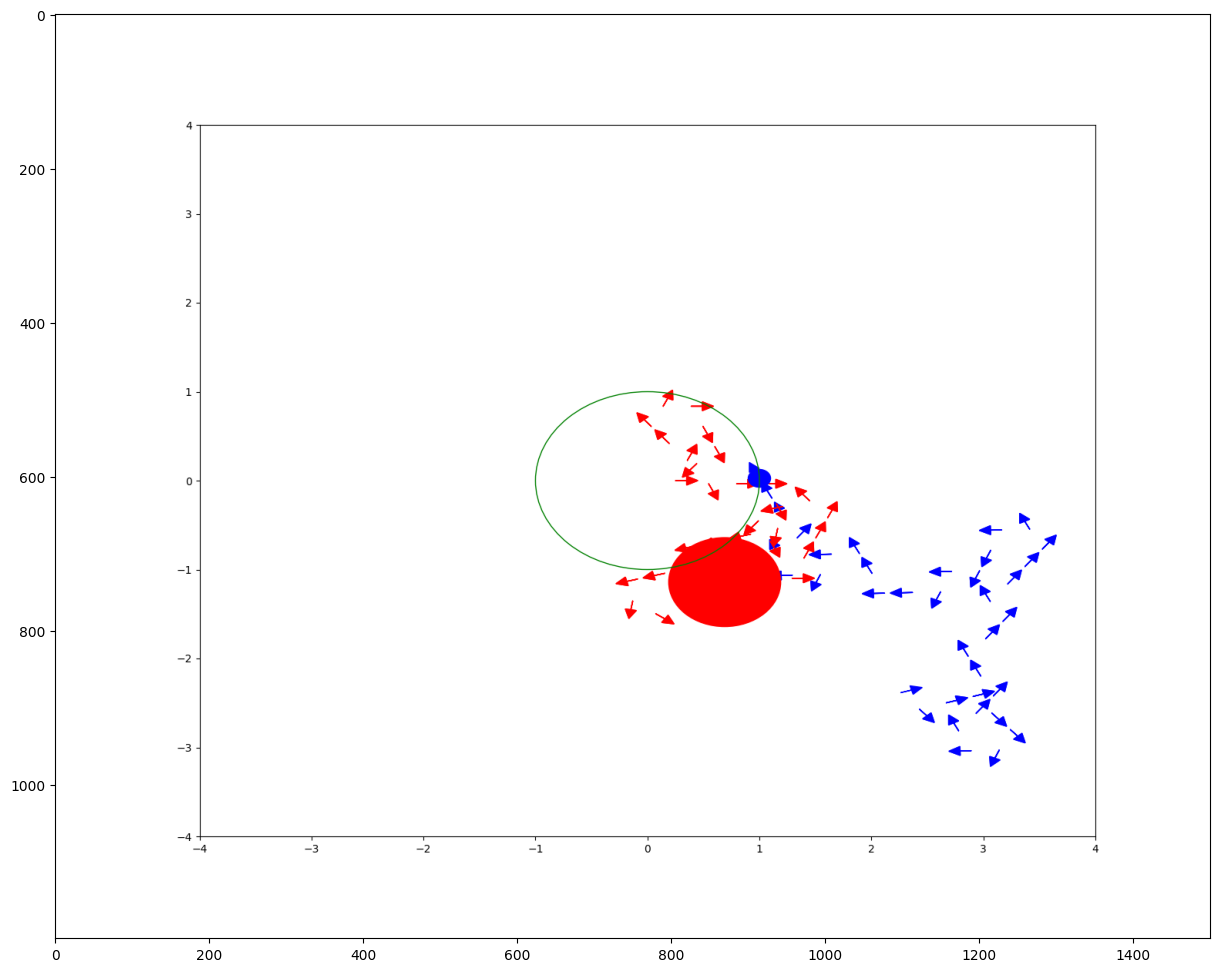

In [91]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,12)
plt.imshow(img)


In [81]:
loaded_params

{'defender': {'linear': {'w': Array([[-0.19250703, -0.23353657, -0.03204549, ...,  0.20527878,
            0.02122679,  0.38153166],
          [ 0.31905448,  0.5354601 ,  0.27213556, ..., -0.16749977,
           -0.00782722, -0.36705336],
          [ 0.14539967, -0.43215317, -0.34633142, ..., -0.01690651,
            0.10922641,  0.19700752],
          ...,
          [ 0.19543508, -0.02237942, -0.1439357 , ...,  0.1071602 ,
            0.05514612, -0.14438154],
          [ 0.09483041,  0.10220437, -0.2915171 , ...,  0.09907509,
            0.27369666,  0.03422914],
          [ 0.04885319,  0.04388625,  0.5212928 , ..., -0.09495788,
            0.01168418, -0.04191492]], dtype=float32),
   'b': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 